In [17]:
import ast
import random
import pickle
import json

import pandas as pd
import numpy as np
from numpy.linalg.linalg import LinAlgError
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
import seaborn as sns
from matplotlib_venn import venn2, venn3, venn3_circles
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import fdrcorrection
import dateutil
from sklearn.linear_model import LinearRegression
from scipy.stats import chi2

In [3]:
# colors and class-superclass maps
with open(r'..\data\metadata\color_schemes.json') as infile:
    colors = json.load(infile)

animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic =     [1076, 1082, 1101]
impaired =     [1060, 1062, 1074, 1092, 1102]
normal =       [1091, 1093]
animal_tol = {
    1076: 'diabetic', 1082: 'diabetic', 1101: 'diabetic', 1060: 'impaired', 1062: 'impaired', 
    1074: 'impaired', 1092: 'impaired', 1102: 'impaired', 1091: 'normal', 1093: 'normal'}
ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Use data that was sent to collaborators 
data = pd.read_csv(r'..\data\processed\combined_metabolites_data_with_model_params.csv').set_index('i')
data_cols = data.filter(regex='FBG|RBG').columns
fbg_cols = data.filter(regex='FBG').columns
rbg_cols = data.filter(regex='RBG').columns
pval_cols = data.filter(regex='pval').columns

n = data.filter(regex='1091|1093')                 # normal
i = data.filter(regex='1060|1062|1074|1092|1102')  # impaired
d = data.filter(regex='1076|1082|1101')            # diabetic

f = data[fbg_cols]  # fasted
r = data[rbg_cols]  # random-fed

fn = n.filter(fbg_cols)  # fasted normal 
fi = i.filter(fbg_cols)  # fasted impaired
fd = d.filter(fbg_cols)  # fasted diabetic

rn = n.filter(rbg_cols)  # random normal
ri = i.filter(rbg_cols)  # random impaired
rd = d.filter(rbg_cols)  # random diabetic

# rename columns to remove '_RBG', '_FBG' for element-wise subtraction
rn.columns = rn.columns.str[:-4]
fn.columns = fn.columns.str[:-4]
ri.columns = ri.columns.str[:-4]
fi.columns = fi.columns.str[:-4]
rd.columns = rd.columns.str[:-4]
fd.columns = fd.columns.str[:-4]

qval_sampling = data['qval_sampling']
# qval_sampling.replace(np.nan, 1, inplace=True)  # For replacing blanks (model failed to converge) with 1
qval_gtol = data['qval_ogtt']
qval_cross = data['qval_sampling:ogtt']

In [4]:
# ogtt = pd.read_csv(r'..\data\processed\OGTT_fixed_effects_lm_results.csv', index_col=0)
# bg = pd.read_csv(r'..\data\processed\Weekly_BG_fixed_effects_lm_results.csv', index_col=0)

In [5]:
data

,unique_id,RT,m/z,adduct,Type,polarity,ID,1102_8_RBG,1093_9_RBG,1060_8_FBG,...,qval_sampling,qval_ogtt,qval_sampling:ogtt,pval_sampling,pval_ogtt,pval_sampling:ogtt,model_param_Intercept,model_param_sampling[T.RBG],model_param_ogtt,model_param_sampling[T.RBG]:ogtt
i,,,,,,,,,,,,,,,,,,,,,
m_0,unknown_2.353_141.06591,2.353,141.06591,[M-H]-1,metabolite,-,unknown,16.861652,16.671317,17.594730,...,6.086023e-01,0.000230,0.631782,5.498881e-01,0.000028,0.520258,15.536056,-0.696204,6.955843e-05,0.000023
m_1,unknown_11.539_180.0585,11.539,180.05850,[M-H]-1,metabolite,-,unknown,22.144573,20.963399,20.198771,...,2.768886e-10,0.002792,0.000126,6.116236e-11,0.000611,0.000003,21.056889,-0.967682,-6.598915e-06,0.000044
m_2,Urocanic acid_11.365_139.05028,11.365,139.05028,[M+H]+1,metabolite,+,Urocanic acid,22.576981,23.843259,23.895235,...,1.823227e-01,0.657168,0.685202,1.412000e-01,0.534845,0.582536,23.314805,0.067803,-6.092324e-07,-0.000009
m_3,Uridine_7.513_243.06152,7.513,243.06152,[M-H]-1,metabolite,-,Uridine,23.803795,24.316310,24.714910,...,1.263455e-10,0.085332,0.537969,2.563897e-11,0.040026,0.416631,24.923579,-0.940619,-9.615231e-06,0.000005
m_4,Uric acid_12.732_167.02007,12.732,167.02007,[M-H]-1,metabolite,-,Uric acid,24.596731,26.201371,17.148994,...,4.025503e-01,0.040372,0.259251,3.452344e-01,0.016251,0.151978,29.615121,-3.092657,-1.235729e-04,0.000091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
l_868,TG 18:0_18:0_18:0_19.885_908.86542,19.885,908.86542,NaN,lipid,+,TG 18:0_18:0_18:0,20.930734,20.351041,20.999142,...,1.446566e-02,0.003268,0.006008,8.989308e-03,0.000744,0.000817,20.114299,-1.661763,2.209284e-07,0.000051
l_869,unknown_20.144_948.89648,20.144,948.89648,NaN,lipid,+,unknown,19.535142,19.313450,19.774817,...,7.182245e-02,0.400770,0.005990,5.036651e-02,0.275446,0.000805,19.687001,-2.914414,-2.865160e-05,0.000083
l_870,unknown_20.148_897.82532,20.148,897.82532,NaN,lipid,+,unknown,18.104875,18.387917,20.517490,...,1.166334e-08,0.278988,0.005976,3.220416e-09,0.174484,0.000793,20.429506,-3.763527,-1.689329e-05,0.000055


In [6]:
ogtt_values = ap.loc[ap['lcms_sampled'], 'OGTT (AUC)']
min_ogtt, max_ogtt = min(ogtt_values), max(ogtt_values)

In [7]:
def get_model_params(feature, df): 
#     params = ast.literal_eval(df.loc[feature]['full_model_params'])
    interceptfbg = df.loc[feature, 'model_param_Intercept']
    interceptrbg = interceptfbg + df.loc[feature, 'model_param_sampling[T.RBG]']
    ogtt_param = df.loc[feature, 'model_param_ogtt']
    sampling_ogtt_cross_param = df.loc[feature, 'model_param_sampling[T.RBG]:ogtt']
    
    minfbg = interceptfbg + ogtt_param * min_ogtt
    minrbg = interceptrbg + ogtt_param * min_ogtt + sampling_ogtt_cross_param * min_ogtt
    maxfbg = interceptfbg + ogtt_param * max_ogtt
    maxrbg = interceptrbg + ogtt_param * max_ogtt + sampling_ogtt_cross_param * max_ogtt
    
    return {'RBG': [[min_ogtt, max_ogtt], [minrbg, maxrbg]],
            'FBG': [[min_ogtt, max_ogtt], [minfbg, maxfbg]]}  
test = get_model_params('l_648', data)
test

{'RBG': [[19060.0, 60245.0], [18.228873795476847, 19.644315728854853]],
 'FBG': [[19060.0, 60245.0], [19.922281667744507, 17.250729443937846]]}

In [7]:
subset.sort_values('qval_sampling:ogtt').iloc[0].name

NameError: name 'subset' is not defined

In [22]:
def pval_text(pval):
    if pval < 0.001:
        return '< 0.001'
    elif pval < 0.01:
        return '< 0.01'
#     elif pval < 0.05:
    else:
        return f'= {round(pval, 3)}'

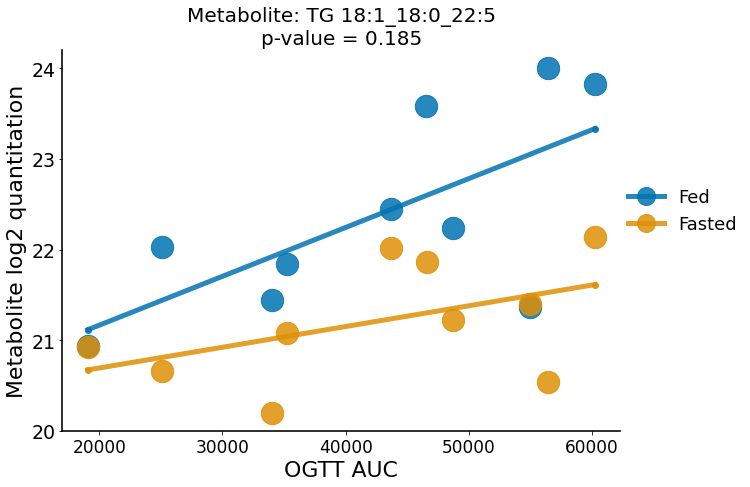

In [23]:
animal_ogtts = ap.loc[ap['lcms_sampled']].filter(regex='OGTT \(AUC\)')

# feature = random.sample(list(data.index), 1)[0]
# feature = 'm_548'
subset = data.loc[
    (~data['unique_id'].str.contains('unknown')) & \
#     (data['Type'] == 'lipid') & \
    (data['Type'] == 'metabolite') & \
#     (data['molec_class'] != 'TG') & \
    (data['qval_ogtt'] < 0.05) & \
    (data['qval_sampling:ogtt'] < 0.05)
]
# feature = data.loc[(~data['unique_id'].str.contains('unknown')) & (data['Type'] == 'lipid')]\
#               .sort_values('qval_sampling:ogtt').iloc[0].name
feature = 'l_762'  # m_123 = Glucose
# feature = subset.sort_values('qval_sampling:ogtt').iloc[0].name

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
fig.set_facecolor('white')
params = get_model_params(feature, data)

for bg_type, bg_color, offset in zip(['RBG', 'FBG'], [colors['RBG'], colors['FBG']], [-5, 5]):
    label = ('Fed' if bg_type == 'RBG' else 'Fasted')
    ax.plot(params[bg_type][0], params[bg_type][1], color=bg_color,
            linewidth=5, alpha=0.85, label=label)
    for animal in animals_used:
        gluc_tol = animal_tol[animal]
        animal_ogtt = animal_ogtts.loc[animal]
        df = data.loc[feature, data.filter(regex=str(animal)).filter(regex=bg_type).columns]
#         plt.scatter(np.array([animal_ogtt]*3) + offset, df, color=bg_color, alpha=0.85, s=200)
        plt.scatter(np.array([animal_ogtt]*1) + offset, df.mean(), color=bg_color, alpha=0.85, s=500)
plt.ylabel('Metabolite log2 quantitation', fontsize=22)
plt.yticks(range(round(plt.ylim()[0]), round(plt.ylim()[1])+1), fontsize=19)
plt.xlabel('OGTT AUC', fontsize=22)  # \nOral Glucose Tolerance Test Area Under Curve
plt.xticks(range(20000, 60001, 10000), fontsize=17)

interaction_pval = pval_text(data.loc[feature, qval_cross.name])
ogtt_pval = pval_text(data.loc[feature, qval_gtol.name])
# feature_pvalue = round(data.loc[feature, qval_cross.name], 3)
plt.title('Metabolite: ' + str(data.loc[feature, 'ID']) + \
#           f'\ninteraction term p-value {interaction_pval}' + \
#           f'\nglucose tolerance p-value {ogtt_pval}'
          f'\np-value {interaction_pval}', fontsize=20)

handles, labels = ax.get_legend_handles_labels()
handles = [x.set_marker('o') for x in handles]
plt.legend(loc=(1, 0.5), fontsize=18, markerscale=3, frameon=False)
# for ogtt_value in animal_ogtts.iloc[:, 0]:
#     plt.vlines(x=ogtt_value, ymin=ylim[0], ymax=ylim[1], color='gray', alpha=0.2)
sns.despine()
[x.set_linewidth(1.6) for x in ax.spines.values()];  # Set width of Spines 
# plt.savefig(r'..\reports\figures\3-5-0\glucose.svg', dpi=300, bbox_inches='tight', facecolor='white')
# plt.savefig(r'..\reports\figures\3-5-0\glucose.png', dpi=300, bbox_inches='tight', facecolor='white')

In [24]:
data.loc['l_762']

unique_id                           TG 18:1_18:0_22:5_17.462_952.83173
RT                                                              17.462
m/z                                                          952.83173
adduct                                                             NaN
Type                                                             lipid
                                                   ...                
pval_sampling:ogtt                                             0.09689
model_param_Intercept                                        20.235796
model_param_sampling[T.RBG]                                   -0.14802
model_param_ogtt                                              0.000023
model_param_sampling[T.RBG]:ogtt                              0.000031
Name: l_762, Length: 78, dtype: object

In [37]:
data.loc['m_135'].filter(regex='model_param')

model_param_Intercept               15.004706
model_param_sampling[T.RBG]         -2.082508
model_param_week[T.8]                 1.50305
model_param_week[T.9]                0.462843
model_param_litter[T.1]              0.668387
model_param_litter[T.2]              0.879926
model_param_litter[T.3]             -0.538849
model_param_ogtt                     0.001357
model_param_sampling[T.RBG]:ogtt     0.000132
model_param_insulin                 -0.002342
model_param_weight                   0.050261
Name: m_135, dtype: object

Good metablites with small p-val in cross

5: lactic acid
6: Threonine
9: Threonine

In [26]:
round(data.loc[feature, qval_cross.name], 4)

0.0097

In [11]:
data.loc[data['ID'] == '3-Hydroxybutyric acid']

,unique_id,RT,m/z,adduct,Type,polarity,ID,1102_8_RBG,1093_9_RBG,1060_8_FBG,...,qval_sampling,qval_ogtt,qval_sampling:ogtt,pval_sampling,pval_ogtt,pval_sampling:ogtt,model_param_Intercept,model_param_sampling[T.RBG],model_param_ogtt,model_param_sampling[T.RBG]:ogtt
i,,,,,,,,,,,,,,,,,,,,,
m_259,3-Hydroxybutyric acid_9.527_103.03895,9.527,103.03895,[M-H]-1,metabolite,-,3-Hydroxybutyric acid,24.87455,24.259398,25.355304,...,3.688593e-13,0.406648,0.008076,5.006474e-14,0.280027,0.001284,26.896228,-3.227636,-0.000026,0.00004


In [16]:
data

,unique_id,RT,m/z,adduct,Type,polarity,ID,1102_8_RBG,1093_9_RBG,1060_8_FBG,...,qval_sampling,qval_ogtt,qval_sampling:ogtt,pval_sampling,pval_ogtt,pval_sampling:ogtt,model_param_Intercept,model_param_sampling[T.RBG],model_param_ogtt,model_param_sampling[T.RBG]:ogtt
i,,,,,,,,,,,,,,,,,,,,,
m_0,unknown_2.353_141.06591,2.353,141.06591,[M-H]-1,metabolite,-,unknown,16.861652,16.671317,17.594730,...,6.086023e-01,0.000230,0.631782,5.498881e-01,0.000028,0.520258,15.536056,-0.696204,6.955843e-05,0.000023
m_1,unknown_11.539_180.0585,11.539,180.05850,[M-H]-1,metabolite,-,unknown,22.144573,20.963399,20.198771,...,2.768886e-10,0.002792,0.000126,6.116236e-11,0.000611,0.000003,21.056889,-0.967682,-6.598915e-06,0.000044
m_2,Urocanic acid_11.365_139.05028,11.365,139.05028,[M+H]+1,metabolite,+,Urocanic acid,22.576981,23.843259,23.895235,...,1.823227e-01,0.657168,0.685202,1.412000e-01,0.534845,0.582536,23.314805,0.067803,-6.092324e-07,-0.000009
m_3,Uridine_7.513_243.06152,7.513,243.06152,[M-H]-1,metabolite,-,Uridine,23.803795,24.316310,24.714910,...,1.263455e-10,0.085332,0.537969,2.563897e-11,0.040026,0.416631,24.923579,-0.940619,-9.615231e-06,0.000005
m_4,Uric acid_12.732_167.02007,12.732,167.02007,[M-H]-1,metabolite,-,Uric acid,24.596731,26.201371,17.148994,...,4.025503e-01,0.040372,0.259251,3.452344e-01,0.016251,0.151978,29.615121,-3.092657,-1.235729e-04,0.000091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
l_868,TG 18:0_18:0_18:0_19.885_908.86542,19.885,908.86542,NaN,lipid,+,TG 18:0_18:0_18:0,20.930734,20.351041,20.999142,...,1.446566e-02,0.003268,0.006008,8.989308e-03,0.000744,0.000817,20.114299,-1.661763,2.209284e-07,0.000051
l_869,unknown_20.144_948.89648,20.144,948.89648,NaN,lipid,+,unknown,19.535142,19.313450,19.774817,...,7.182245e-02,0.400770,0.005990,5.036651e-02,0.275446,0.000805,19.687001,-2.914414,-2.865160e-05,0.000083
l_870,unknown_20.148_897.82532,20.148,897.82532,NaN,lipid,+,unknown,18.104875,18.387917,20.517490,...,1.166334e-08,0.278988,0.005976,3.220416e-09,0.174484,0.000793,20.429506,-3.763527,-1.689329e-05,0.000055


NameError: name 'ogtt' is not defined

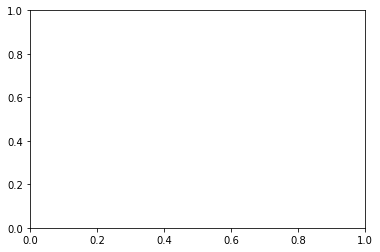

In [15]:
animal_ogtts = ap.loc[ap['lcms_sampled']].filter(regex='OGTT \(AUC\)')

# feature = random.sample(list(data.index), 1)[0]
feature = 'm_548'
# feature = data.loc[~(data['molec_class'].str.contains('unknown')) & \
#                    (data['Type'] == 'metabolite')] \
#               .sort_values(qval_cross.name).iloc[2] 
# print(feature['ID'])
# feature = feature.name
# print(feature)

fig, ax = plt.subplots()
fig.set_facecolor('white')
params = get_model_params(feature, ogtt)

for bg_type, bg_color, offset in zip(['RBG', 'FBG'], [colors['RBG'], colors['FBG']], [-5, 5]):
    ax.plot(params[bg_type][0], params[bg_type][1], label=bg_type, color=bg_color)
    for animal in animals_used:
        gluc_tol = animal_tol[animal]
        animal_ogtt = animal_ogtts.loc[animal]
        df = data.loc[feature, data.filter(regex=str(animal)).filter(regex=bg_type).columns]
        plt.scatter(np.array([animal_ogtt]*3) + offset, df, color=bg_color, alpha=0.85)
plt.ylabel('log2 feature abundance', fontsize=12)
plt.xlabel('OGTT (AUC)', fontsize=12)
feature_pvalue = round(data.loc[feature, qval_cross.name], 4)
plt.title(data.loc[feature, 'Proposed ID'] + f'\np-value = {feature_pvalue}', fontsize=14)
plt.legend(loc=(1, 0.5))
ylim = ax.get_ylim()
for ogtt_value in animal_ogtts.iloc[:, 0]:
    plt.vlines(x=ogtt_value, ymin=ylim[0], ymax=ylim[1], color='gray', alpha=0.2)
# plt.xticks(animal_ogtts.iloc[:, 0])
sns.despine()

In [21]:


animal_ogtts = ap.loc[ap['lcms_sampled']].filter(regex='OGTT \(AUC\)')

# feature = random.sample(list(data.index), 1)[0]
# feature = 'm_548'
feature = data.loc[~(data['Unique ID'].str.contains('unknown')) & \
                   (data['Type'] == 'metabolite')] \
              .sort_values(qval_gtol.name).iloc[10] 
print(feature['ID'])
feature = feature.name
print(feature)

fig, ax = plt.subplots()
fig.set_facecolor('white')
params = get_model_params(feature, ogtt)

for bg_type, bg_color, offset in zip(['RBG', 'FBG'], [colors['RBG'], colors['FBG']], [-5, 5]):
    ax.plot(params[bg_type][0], params[bg_type][1], label=bg_type, color=bg_color)
    for animal in animals_used:
        gluc_tol = animal_tol[animal]
        animal_ogtt = animal_ogtts.loc[animal]
        df = data.loc[feature, data.filter(regex=str(animal)).filter(regex=bg_type).columns]
        plt.scatter(np.array([animal_ogtt]*3) + offset, df, color=bg_color, alpha=0.85)
plt.ylabel('log2 feature abundance', fontsize=12)
plt.xlabel('OGTT (AUC)', fontsize=12)
feature_pvalue = round(data.loc[feature, qval_gtol.name], 4)
plt.title(data.loc[feature, 'Proposed ID'] + f'\np-value = {feature_pvalue}', fontsize=14)
plt.legend(loc=(1, 0.5))
ylim = ax.get_ylim()
for ogtt_value in animal_ogtts.iloc[:, 0]:
    plt.vlines(x=ogtt_value, ymin=ylim[0], ymax=ylim[1], color='gray', alpha=0.2)
# plt.xticks(animal_ogtts.iloc[:, 0])
sns.despine()

KeyError: 'Unique ID'

In [6]:
d = {'RBG': {}, 'FBG': {}}

for animal in animals_used:
    for df, bg_type in zip([f, r], ['FBG', 'RBG']):
        bg_type_animal_mean = df.filter(regex=str(animal)).mean(axis=1)
        d['RBG'][animal] = bg_type_animal_mean 
d

{'RBG': {1091: i
  l_0      23.966487
  l_1      24.912942
  l_2      23.413989
  l_3      27.350338
  l_4      22.522382
             ...    
  m_169    25.124559
  m_213    23.324871
  m_24     27.744507
  m_505    21.655395
  m_441    22.617104
  Length: 1727, dtype: float64,
  1093: i
  l_0      23.611918
  l_1      24.567604
  l_2      23.952991
  l_3      26.970232
  l_4      22.766641
             ...    
  m_169    25.198418
  m_213    22.464199
  m_24     27.636194
  m_505    21.183386
  m_441    22.558525
  Length: 1727, dtype: float64,
  1060: i
  l_0      23.840615
  l_1      25.054730
  l_2      24.048209
  l_3      26.942758
  l_4      23.111682
             ...    
  m_169    24.832177
  m_213    21.665979
  m_24     27.396343
  m_505    20.623551
  m_441    22.525861
  Length: 1727, dtype: float64,
  1062: i
  l_0      23.174288
  l_1      23.608273
  l_2      23.749417
  l_3      27.198735
  l_4      22.836285
             ...    
  m_169    24.855207
  m_213    23.623

In [7]:
feature = 'l_557'
test = get_model_fits(feature, ogtt)

plt.plot(test['RBG'][0], test['RBG'][1], c=colors['RBG'], label='random-fed')
plt.plot(test['FBG'][0], test['FBG'][1], c=colors['FBG'], label='fasted')


for bg_type in ['RBG', 'FBG']:
    for animal in animals_used:
        plt.scatter()
    

plt.scatter()

plt.legend()

NameError: name 'get_model_fits' is not defined

In [171]:
import pygal

In [180]:
pygal.style.BlueStyle()

In [177]:
plt.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'both',
          'axes.gri

In [186]:
plt.rcParams

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'both',
          'axes.grid.which':